In [171]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD

np.random.seed(0)

### Food.com   Dataset
- https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions
- https://aclanthology.org/D19-1613/

In [172]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [173]:
!gdown https://drive.google.com/uc?id=1dK__rulbUEGU_m68RIK7Qevc7pcpOIme
!gdown https://drive.google.com/uc?id=1dN-wpxE3V8yNVKPByHReEaswl9UNV9wj

Downloading...
From: https://drive.google.com/uc?id=1dK__rulbUEGU_m68RIK7Qevc7pcpOIme
To: /content/RAW_recipes.csv
100% 295M/295M [00:01<00:00, 271MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dN-wpxE3V8yNVKPByHReEaswl9UNV9wj
To: /content/RAW_interactions.csv
100% 349M/349M [00:01<00:00, 229MB/s]


In [174]:
raw_interactions_df = pd.read_csv('RAW_interactions.csv')
raw_interactions_df['review']= raw_interactions_df['review'].astype(str)
raw_interactions_df.head(5)

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [175]:
raw_recipes_df = pd.read_csv('RAW_recipes.csv')

raw_recipes_df.head(5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [176]:
raw_interactions_df.info()
rating_df=raw_interactions_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user_id    1132367 non-null  int64 
 1   recipe_id  1132367 non-null  int64 
 2   date       1132367 non-null  object
 3   rating     1132367 non-null  int64 
 4   review     1132367 non-null  object
dtypes: int64(3), object(2)
memory usage: 43.2+ MB


### Prepare dataset

In [177]:
rating_df=rating_df[['user_id','recipe_id','date','rating']]
rating_df.rename(columns = {'user_id':'userID', 'recipe_id':'itemID'}, inplace = True)

x = rating_df.groupby('itemID').count()['rating'] >= 40
userIndex = x[x].index
nm_rating_df=rating_df[rating_df['itemID'].isin(userIndex)]
y = nm_rating_df.groupby('userID').count()['rating']>=60
items = y[y].index
rating_df = nm_rating_df[nm_rating_df['userID'].isin(items)]
rating_df.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(50686, 4)

In [178]:
unique_users = rating_df.userID.unique()
user_ids = dict(zip(unique_users, np.arange(unique_users.shape[0], dtype=np.int32)))

unique_items = rating_df.itemID.unique()
item_ids = dict(zip(unique_items, np.arange(unique_items.shape[0], dtype=np.int32)))

In [179]:
product_ids = list(set(list(rating_df.itemID.unique())))
user_ids = list(set(list(rating_df.userID.unique())))

### Train and test dataset

In [180]:
test_df=rating_df.groupby('userID').head(15)
test_df.shape

(7005, 4)

In [181]:
train_df=rating_df[~rating_df.isin(test_df).all(1)]
train_df.shape

(43681, 4)

##### Install packages

In [182]:
!pip install networkx
!pip install stellargraph
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [183]:
graph_df=train_df
graph_df=graph_df[['userID','itemID','rating']]
graph_df.columns = ['source', 'target', 'weights']
graph_df.head(1)

,source,target,weights
12666,140132,14569,4


### Sentimant analysis on the data
- It will take lot of time

### Look at distribution of ratings

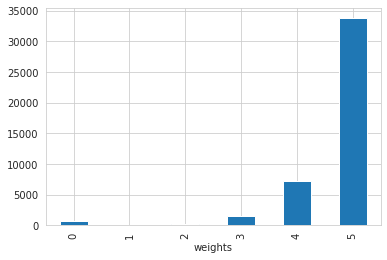

In [184]:
graph_df.groupby(['weights']).size().plot(kind = "bar")

### Contant Based Filtering

- This data frame contain large number of records.So we will apply multiple filtering before applying similarity methods.
- First we filter out records that got more negetive feedback.No point to recommend such items to users
- Also we will consider items that got high feedback from user

In [185]:
contant_df=train_df .merge( raw_recipes_df, left_on='itemID', right_on='id', how='left').fillna(0)

In [186]:
contant_df.head(1)

,userID,itemID,date,rating,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,140132,14569,2009-04-12,4,strawberry strawberry pie from the really good...,14569,35,9045,2001-11-19,"['60-minutes-or-less', 'time-to-make', 'course...","[299.3, 15.0, 127.0, 9.0, 6.0, 12.0, 16.0]",11,"['pre-bake pie crust', 'cool', 'slice the stra...",one of the easiest and best desserts! twice th...,"['pie crust', 'strawberry', 'strawberry jell-o...",8


###  contant filtering

#### Nutrition values also seems to be very good candidate for filtering data

In [187]:
contant_df['nutrition_f2']=contant_df['nutrition'].str.split(',', expand = True)[1]
contant_df['nutrition_f2']=contant_df['nutrition_f2'].astype(float)
contant_df['nutrition_f1']=contant_df['nutrition'].str.split(',', expand = True)[0]
contant_df['nutrition_f1']=contant_df['nutrition_f1'].str.replace('[','').astype(float)
contant_df['nutrition_f3']=contant_df['nutrition'].str.split(',', expand = True)[2]
contant_df['nutrition_f3']=contant_df['nutrition_f3'].astype(float)
contant_df['nutrition_f4']=contant_df['nutrition'].str.split(',', expand = True)[3]
contant_df['nutrition_f4']=contant_df['nutrition_f4'].astype(float)
contant_df['nutrition_f5']=contant_df['nutrition'].str.split(',', expand = True)[4]
contant_df['nutrition_f5']=contant_df['nutrition_f5'].str.replace('[','').astype(float)
contant_df['nutrition_f6']=contant_df['nutrition'].str.split(',', expand = True)[5]
contant_df['nutrition_f6']=contant_df['nutrition_f6'].astype(float)

contant_df['nutrition_f7']=contant_df['nutrition'].str.split(',', expand = True)[6]
contant_df['nutrition_f7']=contant_df['nutrition_f7'].str.replace(']','').astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  from ipykernel import kernelapp as app


In [188]:
contant_df.head(1)

,userID,itemID,date,rating,name,id,minutes,contributor_id,submitted,tags,...,description,ingredients,n_ingredients,nutrition_f2,nutrition_f1,nutrition_f3,nutrition_f4,nutrition_f5,nutrition_f6,nutrition_f7
0,140132,14569,2009-04-12,4,strawberry strawberry pie from the really good...,14569,35,9045,2001-11-19,"['60-minutes-or-less', 'time-to-make', 'course...",...,one of the easiest and best desserts! twice th...,"['pie crust', 'strawberry', 'strawberry jell-o...",8,15.0,299.3,127.0,9.0,6.0,12.0,16.0


In [189]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

contant_df[['nutrition_f1','nutrition_f2','nutrition_f3','nutrition_f4','nutrition_f5','nutrition_f6','nutrition_f7']]=scaler.fit_transform(contant_df[['nutrition_f1','nutrition_f2','nutrition_f3','nutrition_f4','nutrition_f5','nutrition_f6','nutrition_f7']])



In [190]:
nutrition_df=contant_df[['nutrition_f1','nutrition_f2','nutrition_f3','nutrition_f4','nutrition_f5','nutrition_f6','nutrition_f7']]

processing for k=1
processing for k=2
processing for k=3
processing for k=4
processing for k=5
processing for k=6
processing for k=7
processing for k=8
processing for k=9
processing for k=10
processing for k=11
processing for k=12
processing for k=13
processing for k=14
processing for k=15
processing for k=16
processing for k=17
processing for k=18
processing for k=19
processing for k=20
processing for k=21
processing for k=22
processing for k=23
processing for k=24
processing for k=25
processing for k=26
processing for k=27
processing for k=28
processing for k=29
processing for k=30
processing for k=31
processing for k=32
processing for k=33
processing for k=34
processing for k=35
processing for k=36
processing for k=37
processing for k=38
processing for k=39
processing for k=40


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


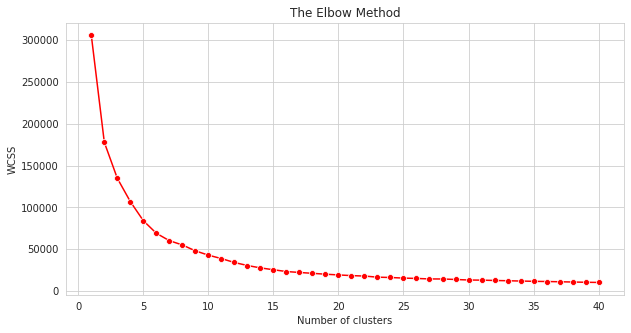

In [191]:

from sklearn.cluster import KMeans

num_clust = 40

wcss = []

for i in range(1, num_clust+1):
    print(f'processing for k={i}')
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(nutrition_df)
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,5))

sns.lineplot(range(1, num_clust+1), wcss,marker='o',color='red')

plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


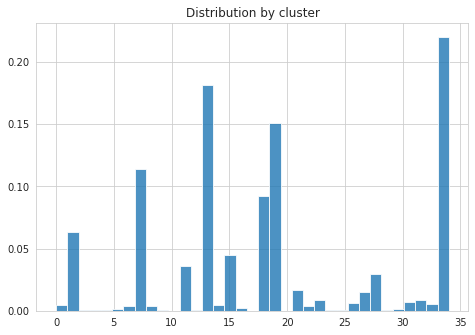

In [192]:
num_clust = 35

kmeans = KMeans(n_clusters = num_clust, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(nutrition_df)

nutrition_df.loc[:, 'cluster'] = y_kmeans

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.hist(
    y_kmeans,
    bins=num_clust,
    density=True,
    alpha=0.8
)

plt.title('Distribution by cluster')
plt.show()

In [193]:
contant_df['cluster']=nutrition_df['cluster']

### Prepare data for graph embedding

In [194]:
food_cluster_edgelist = contant_df[['itemID', 'cluster']]
food_cluster_edgelist.head(1)

,itemID,cluster
0,14569,18


In [195]:
food_cluster_edgelist.drop_duplicates()

,itemID,cluster
0,14569,18
1,9004,19
2,37413,19
3,25502,7
4,51997,18
...,...,...
43582,43072,19
43583,38966,18
43611,137575,19
43659,31040,13


In [196]:
food_cluster_edgelist=food_cluster_edgelist[food_cluster_edgelist['itemID'].isin(list(graph_df['target']))]

In [197]:
food_cluster_graph = nx.Graph()
for x in food_cluster_edgelist.values:
    item = x[0]
    cluster = x[1]
   
    food_cluster_graph.add_node(item)
    food_cluster_graph.add_node(cluster)
    food_cluster_graph.add_edge(item, cluster, weight=3)
           

In [198]:
user_item_edge_list = graph_df[['source', 'target', 'weights']]
user_item_edge_list.head()

,source,target,weights
12666,140132,14569,4
12890,140132,9004,5
14822,140132,37413,5
16026,140132,25502,5
18820,140132,51997,5


In [199]:
user_item_graph = nx.Graph()
for x in user_item_edge_list.values:

    usr = x[0]
    item = x[1]
    user_item_graph.add_node(usr)
    user_item_graph.add_node(item)
    user_item_graph.add_edge(usr, item, weight=float(x[2]))

In [200]:
final_graph =  nx.Graph()
final_graph.add_weighted_edges_from([(x,y,food_cluster_graph[x][y]['weight']) for x,y in food_cluster_graph.edges()])
final_graph.add_weighted_edges_from([(x,y,user_item_graph[x][y]['weight']) for x,y in user_item_graph.edges()])

### Graph embedding

In [201]:
import networkx as nx
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph

In [202]:

G = G = StellarGraph(final_graph)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Constructing a StellarGraph directly from a NetworkX graph has been replaced by the `StellarGraph.from_networkx` function
  


In [203]:
rw = BiasedRandomWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=80,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 33000


In [204]:

from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

In [205]:
model.save("word2vec1.model")

In [206]:
node_embeddings= model.wv

In [207]:
df=user_item_edge_list['target'].unique()

In [208]:
df=list(df)
df.sort()


In [209]:
contant_df[contant_df.name=="buttermilk pancakes"].head(1)

,userID,itemID,date,rating,name,id,minutes,contributor_id,submitted,tags,...,ingredients,n_ingredients,nutrition_f2,nutrition_f1,nutrition_f3,nutrition_f4,nutrition_f5,nutrition_f6,nutrition_f7,cluster
30,173579,66241,2006-11-01,5,buttermilk pancakes,66241,40,88099,2003-07-07,"['60-minutes-or-less', 'time-to-make', 'course...",...,"['eggs', 'all-purpose flour', 'sugar', 'baking...",11,0.059782,0.217167,0.022894,0.281135,-0.019192,0.179925,0.465425,1


In [210]:
from scipy.spatial.distance import cosine

In [211]:
item=66241
result= {}
for i in df:
  if(i!=item):
    itm2 = i
    cos=0
    try:
      cos=1.0 - cosine(node_embeddings[item], node_embeddings[itm2])
    except:
      pass
    result[i]=cos

In [212]:
from collections import Counter
result=dict(Counter(result).most_common(20))

In [213]:

result= list(result.keys())

In [214]:
result

[153,
 198,
 246,
 432,
 456,
 519,
 536,
 607,
 632,
 647,
 749,
 809,
 822,
 860,
 916,
 1005,
 1035,
 1356,
 1600,
 1985]

In [215]:


contant_df[contant_df['id'].isin(result)].groupby('id').head(1)

,userID,itemID,date,rating,name,id,minutes,contributor_id,submitted,tags,...,ingredients,n_ingredients,nutrition_f2,nutrition_f1,nutrition_f3,nutrition_f4,nutrition_f5,nutrition_f6,nutrition_f7,cluster
9,140132,1356,2010-11-23,5,ground beef stuffed green bell peppers with ch...,1356,50,1555,1999-09-28,"['60-minutes-or-less', 'time-to-make', 'course...",...,"['green peppers', 'beef', 'onion', 'tomatoes',...",9,1.683741,1.057613,-0.054416,0.079465,0.155788,2.038549,0.104762,32
2122,55729,246,2002-11-18,5,lee s hot crab dip,246,45,25843,1999-09-01,"['60-minutes-or-less', 'time-to-make', 'course...",...,"['crabmeat', 'cream cheese', 'sour cream', 'ma...",10,-0.105929,-0.276855,-0.327973,-0.164221,-0.194172,-0.012346,-0.436231,34
5475,4470,519,2003-01-20,0,spicy hash browns homemade,519,45,1773,1999-10-06,"['60-minutes-or-less', 'time-to-make', 'course...",...,"['olive oil', 'paprika', 'chili powder', 'salt...",8,-0.271639,-0.225963,-0.327973,-0.214639,-0.272913,-0.341955,-0.003436,13
10162,95743,860,2004-01-11,5,kentucky biscuits,860,23,1552,1999-08-26,"['30-minutes-or-less', 'time-to-make', 'course...",...,"['flour', 'salt', 'sugar', 'baking powder', 'm...",6,-0.227449,-0.298934,-0.339867,-0.122206,-0.290411,-0.259553,-0.255900,34
13403,20754,632,2002-01-22,4,100 whole wheat blueberry muffins,632,70,1530,1999-09-05,"['weeknight', 'time-to-make', 'course', 'main-...",...,"['whole wheat flour', 'baking soda', 'buttermi...",7,-0.249544,-0.272660,-0.036575,-0.256653,-0.264164,-0.332799,-0.147701,13
15546,13483,607,2002-10-05,5,famous barr s french onion soup,607,265,1634,1999-08-18,"['weeknight', 'time-to-make', 'course', 'main-...",...,"['onions', 'butter', 'black pepper', 'paprika'...",12,-0.249544,-0.315383,-0.226876,0.079465,-0.255415,-0.204618,-0.255900,13
19828,103876,1985,2005-01-02,5,benihana ginger salad dressing,1985,10,2353,1999-10-10,"['15-minutes-or-less', 'time-to-make', 'course...",...,"['onion', 'peanut oil', 'rice vinegar', 'water...",13,-0.216402,-0.376984,-0.333920,-0.223042,-0.334156,-0.314487,-0.472297,34
20756,133174,456,2005-08-03,5,lentil dal,456,43,1556,1999-08-19,"['60-minutes-or-less', 'time-to-make', 'course...",...,"['olive oil', 'onion', 'fresh ginger', 'cumin ...",15,-0.304781,-0.060810,-0.268504,-0.189430,-0.089184,-0.360266,0.357226,1
20819,22015,1035,2003-01-13,5,puppy chow snack mix,1035,20,163272,1999-08-26,"['30-minutes-or-less', 'time-to-make', 'course...",...,"['chocolate chips', 'butter', 'peanut butter',...",5,0.192350,0.297646,1.277690,-0.139012,-0.159176,0.289794,0.717888,11
21218,486718,809,2011-02-20,5,irish beef stew with guinness stout,809,150,1612,1999-08-28,"['time-to-make', 'course', 'main-ingredient', ...",...,"['olive oil', 'bay leaves', 'beef stew meat', ...",13,-0.072787,0.144858,-0.268504,-0.164221,0.584489,-0.131372,-0.183768,19


## Evaluate our result
- We will generate top 10 recommendations for 100 user and calculate the hit rate in test data set.

In [216]:
userlist=list(graph_df.source.unique())[:100]
data=graph_df[graph_df['source'].isin(userlist)]
test_df=test_df[test_df['userID'].isin(userlist)]
result=data.sort_values(by=['source','weights'],ascending=[True,False])
result=result.groupby('source').head(10)

In [217]:
from collections import Counter
top_n = 10
k = 50
top_n = 10

recommend_dict = { }
for index, row in result.iterrows():
    user=row['source']
    if user not in recommend_dict.keys():
        recommend_dict[user]={}
    
    id=str(row['target']) 
    food1 = id
    res_dict= {}
    for i in df:
      if(i!=id):
        food2 = i
        cos=1.0 - cosine(node_embeddings[food1], node_embeddings[str(food2)])
        res_dict[i]=cos
    
    res=dict(Counter(res_dict).most_common(20))
    indexes= list(res.keys())    
    
  
    for ids in indexes:
        if(ids==id):
            continue
        if(~((result['target'] == ids) & (result['source'] ==user)).any()):
            if ids not in recommend_dict[user].keys():
                recommend_dict[user][ids] =1
            else:
                recommend_dict[user][ids]+=1
                    
        
    
        
        

In [218]:
# Iterating over values
recommendations=[]
for userid, books in recommend_dict.items():
    total=0
    mlist=[]
    for i in books:
        total+=1
        mlist.append(i)
        if(total>10):
            break
    recommendations.append([userid,mlist])

In [219]:
recommendations=pd.DataFrame(recommendations,columns=['user_id','item'])

### HIT Rate

In [220]:
total=0
hit=0
for i in userlist:
    results=recommendations[recommendations.user_id==i]
    results=list(results.item)[0]
    total+=1
    for rs in results:
        
        if(((test_df['itemID'] == rs) & (test_df['userID'] ==i)).any()):
                hit+=1
                break
        
hit_ratio=hit/total   
print(hit_ratio)

0.39


### MAP@K

In [221]:
total=0
hit=0
for i in userlist:
    results=recommendations[recommendations.user_id==i]
    results=list(results.item)[0]
   
    for rs in results:
        total+=1
        if(((test_df['itemID'] == rs) & (test_df['userID'] ==i)).any()):
                hit+=1
                
        
mapk=hit/total   
print(mapk)

0.046363636363636364
